In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.svm import SVR

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.neural_network import MLPRegressor


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from scipy.stats import norm

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

np.random.seed(1)


The idea is from Tatsat, in 'Blueprint for developing a machine learning algorithm for derivative pricing'. Usual theoretic assumptions are in position for derivatives prices. 

The goal is to show that even a simple 4 layered ANN can be used to approximate the Black - Scholes formula with high accuracy

In [ ]:
#volatility parameter, these parameters are with practical significance
alpha = 0.1
beta = 0.1
sigma0 = 0.2

#risk-free-rate.
r = 0.05

In [ ]:

def volatility(moneyness, time_to_maturity): 
  return sigma0 + alpha * time_to_maturity + beta * np.square(moneyness - 1)

In [ ]:
def Black_Scholes(moneyness, time_to_maturity, option_vol): 
  d1=(np.log(1/moneyness)+(r+np.square(option_vol))* time_to_maturity)/ (option_vol*np.sqrt(time_to_maturity)) 
  d2=(np.log(1/moneyness)+(r-np.square(option_vol))* time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
  N_d1 = norm.cdf(d1)
  N_d2 = norm.cdf(d2)
  return N_d1 - moneyness * np.exp(-risk_free_rate*time_to_maturity) * N_d2

In [ ]:

#Generating Data:
"""
K: Strike Price,
T: Time - to - Maturity
Ps: Prices
M : Moneyness (K/S)
"""
N = 10000

Ks = 1 + 0.25*np.random.randn(N)#strike prices
Ts = np.random.random(N)
#Volatilities
Sigmas = np.array([volatility(k,t) for k,t in zip(Ks,Ts)])
#Call option prices

Ps = np.array([Black_Scholes(k,t,sig) for k,t,sig in zip(Ks,Ts,Sigmas)])

In [ ]:
#Creating the data frame:

X = np.concatenate([Ks.reshape(-1,1), Ts.reshape(-1,1), Sigmas.reshape(-1,1)],  axis=1)
Y = Ps
dataset = pd.DataFrame(np.concatenate([Y.reshape(-1,1), X], axis =1),
                       columns = ['Price', 'moneyness','Time','Vol'])


In [ ]:
dataset.head()

,Price,moneyness,Time,Vol
0,0.210672,1.102112,0.965268,0.297569
1,0.023025,1.174613,0.232820,0.226331
2,0.055942,1.001516,0.104342,0.210434
3,0.030157,1.333900,0.458394,0.256988
4,0.008719,1.163549,0.142024,0.216877


<Figure size 1080x1080 with 0 Axes>

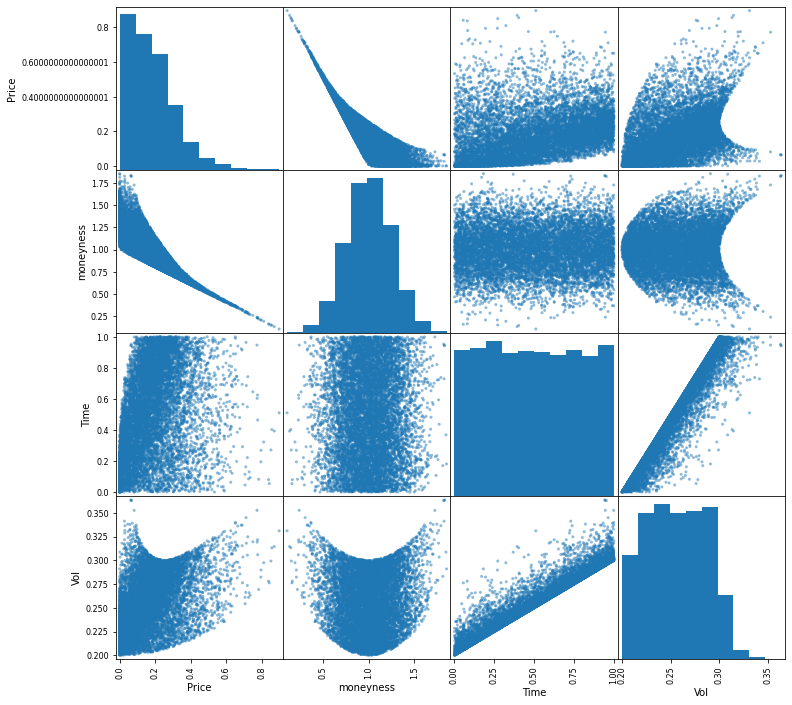

In [ ]:
"""
Non-linear relations are indicating that linear models are not
good for this specific problem.
"""

plt.figure( figsize = (15,15))
scatter_matrix(dataset, figsize = (12,12))
plt.show()

In [ ]:
#feature selection
bestfeatures = SelectKBest(k='all', score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(['Moneyness', 'Time', 'Vol'])
featureScores = pd.concat([dfcolumns,dfscores],axis=1) 
featureScores.columns = ['Specs','Score'] 
#naming the dataframe columns 
featureScores.nlargest(10,'Score').set_index('Specs')

,Score
Specs,
Moneyness,29840.240395
Vol,2215.358369
Time,1436.046771


In [ ]:
#Train - Test split
validation_size = 0.2


train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [ ]:
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'

In [ ]:
models = []
models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
print(models)

[('LR', LinearRegression()), ('KNN', KNeighborsRegressor()), ('CART', DecisionTreeRegressor()), ('SVR', SVR())]


In [ ]:
#ANN
print(models)
models.append(('MLP', MLPRegressor()))
# Boosting methods
models.append(('ABR', AdaBoostRegressor())) 
models.append(('GBR', GradientBoostingRegressor())) # Bagging methods
models.append(('RFR', RandomForestRegressor())) 
models.append(('ETR', ExtraTreesRegressor()))

[('LR', LinearRegression()), ('KNN', KNeighborsRegressor()), ('CART', DecisionTreeRegressor()), ('SVR', SVR())]


In [ ]:
names = []
kfold_results = [] 
test_results = [] 
train_results = []
for name, model in models:
  names.append(name)
  ## k-fold analysis:
  kfold = KFold(n_splits=num_folds)
  #converted mean squared error to positive. The lower the better 
  cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  kfold_results.append(cv_results)
  # Full Training period
  res = model.fit(X_train, Y_train)
  train_result = mean_squared_error(res.predict(X_train), Y_train) 
  train_results.append(train_result)
  # Test results
  test_result = mean_squared_error(res.predict(X_test), Y_test) 
  test_results.append(test_result)

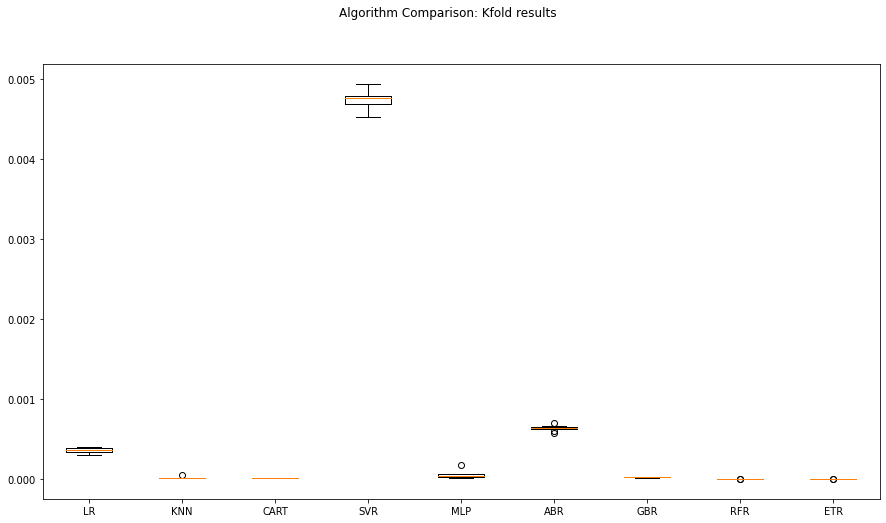

In [ ]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

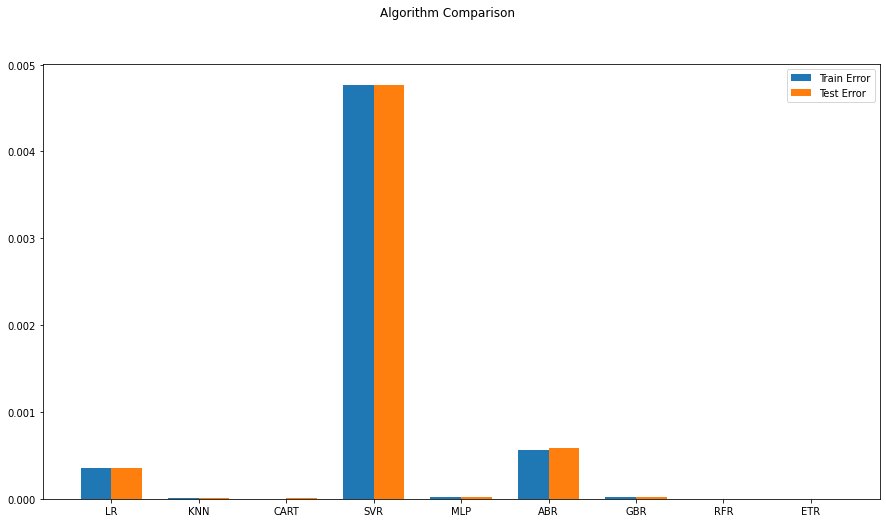

In [ ]:
# compare algorithms
fig = plt.figure()
ind = np.arange(len(names)) # the x locations for the groups
width = 0.35 # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_results,  width=width, label='Train Error')
plt.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.show()

In [62]:
#Searching for hyperpaprameters for MLPRegression
param_grid = {'hidden_layer_sizes':[(20,), (50,), (20,20), (20,30,20),
              (20,20,20,20)]}
model = MLPRegressor()

kfold = KFold(n_splits = num_folds)

GS = GridSearchCV( estimator = model, param_grid = param_grid,
                  scoring = scoring, cv = kfold)
grid_result = GS.fit(X_train,Y_train)
print('Best score {} using {}'.format(grid_result.best_score_, 
                                      grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))





Best score -2.270547943598691e-05 using {'hidden_layer_sizes': (20, 20, 20, 20)}
-0.000635 (0.000538) with: {'hidden_layer_sizes': (20,)}
-0.000236 (0.000361) with: {'hidden_layer_sizes': (50,)}
-0.000097 (0.000108) with: {'hidden_layer_sizes': (20, 20)}
-0.000037 (0.000026) with: {'hidden_layer_sizes': (20, 30, 20)}
-0.000023 (0.000009) with: {'hidden_layer_sizes': (20, 20, 20, 20)}


In [65]:
best_layer_size = (20,20,20,20)
best_MLP = MLPRegressor(hidden_layer_sizes = best_layer_size)
best_MLP.fit(X_train, Y_train)

Y_pred = best_MLP.predict(X_test)

print('maen-squared-error is ', mean_squared_error(Y_test,Y_pred))

maen-squared-error is  4.316391611273521e-05
